In [17]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
import os
import glob

import pre_act_resnet as PreActResNet

ROOT_DIR = 'eval_dataset'

def load_model(num_classes, model_path):
    model = PreActResNet.PreActResNet18(num_classes)
    model.load_state_dict(torch.load(model_path))
    #model = model.to(device)
    model.eval()
    
    return model

def load_test(idx: int):
    test_root_dir = os.path.join(ROOT_DIR, str(idx))
    
    metadata = torch.load(os.path.join(test_root_dir, 'metadata.pt'))

    num_classes = metadata['num_classes']
    ground_truth = metadata['ground_truth']
    images_root_dir = metadata['test_images_folder_address']
    transformation = metadata['transformation']

    model_path = os.path.join(test_root_dir, 'model.pt')

    if images_root_dir[0] == '.':
        images_root_dir = images_root_dir[2:]

    images_path = glob.glob(os.path.join(test_root_dir, images_root_dir, '*.jpg'))
    labels = [int(image_path.split('_')[-1].split('.')[0]) for image_path in images_path]

    model = load_model(num_classes, model_path)

    
    return model, num_classes, ground_truth, transformation, images_path, labels


    

In [19]:
model, num_classes, ground_truth, transformation, images_path, labels = load_test(6)

In [20]:
from PIL import Image

def transform_images(images_path, transformation):
    transformed_images = []
    for img_path in images_path:
        try:
            image = Image.open(img_path).convert('RGB')
            image = transformation(image)
            transformed_images.append(image)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    if not transformed_images:
        raise ValueError("No images were loaded. Please check the images_path list.")

    return torch.stack(transformed_images).to(device)




In [21]:
transformation

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [22]:
from torchvision import transforms

def extract_normalization_params(transformation):

    mean = None
    std = None
    
    for transform in transformation.transforms:
        if isinstance(transform, transforms.Normalize):
            mean = transform.mean
            std = transform.std
    return mean, std

extract_normalization_params(transformation)

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [23]:
transformed_images = transform_images(images_path, transformation)
transformed_images.min()

tensor(-2.1179, device='cuda:0')

In [24]:
import torch.nn.functional as F

def get_logits_and_probs(model, transformed_images):
    model.eval()
    logits = model(transformed_images)
    probabilities = F.softmax(logits, dim=1)
    return probabilities, logits



probs, logits = get_logits_and_probs(model, transformed_images)
logits

tensor([[ 1.2836e+00, -1.8322e-01, -3.3053e+00, -1.8906e+00,  4.5027e+00,
          4.1058e-01,  7.7539e+00, -6.9655e+00, -4.8457e+00, -1.1432e+00],
        [-9.4442e+00,  1.0126e+00, -6.0918e+00, -1.4155e+00, -9.1780e+00,
          6.8723e+00, -4.2169e+00,  6.8554e+00,  7.7998e+00,  1.8375e+01],
        [ 5.1090e-01, -3.8004e+00, -1.6217e+00, -6.4268e+00, -1.7405e+00,
         -6.5236e+00,  1.4428e+01, -3.6477e+00, -3.9999e+00, -1.3646e+01],
        [-4.8183e+00,  1.5517e+01, -5.8074e+00,  3.1980e+00, -2.5911e+00,
         -7.6782e+00,  2.6218e+00, -2.9812e+00, -1.3034e+01,  8.4713e-01],
        [-7.5898e-01, -2.5975e+00,  1.8169e+00, -8.5229e+00, -7.7934e+00,
         -5.8629e+00,  1.0875e+01,  1.4100e-01, -1.7546e+00, -1.0167e+01],
        [-6.7585e+00, -2.0544e-02, -1.9332e+00,  7.2639e+00,  3.7713e+00,
         -5.7788e-01, -2.7178e+00, -4.8533e+00,  1.4012e+00, -1.1266e+00],
        [-4.8694e+00,  4.7457e+00, -4.7107e+00,  1.0659e+01,  1.3427e+00,
         -7.6613e+00,  3.0710e-0

In [25]:
from collections import defaultdict

def calculate_margins(probs, labels):
    accepted_margins = defaultdict(list)
    failed_margins = defaultdict(list)
    for i in range(len(probs)):
        topk = torch.topk(probs[i], k=3, largest=True, sorted=True)
        topk_values = topk.values
    
        margin = topk_values[0].item() - topk_values[1].item()
        if labels[i] == torch.argmax(probs[i]).item():
            accepted_margins[labels[i]].append(margin)
        else:
            failed_margins[torch.argmax(probs[i]).item()].append(margin)
    return accepted_margins, failed_margins

accepted_margins, failed_margins = calculate_margins(logits, labels)
print(failed_margins)

defaultdict(<class 'list'>, {6: [4.297548294067383, 2.743225336074829], 2: [9.910642623901367]})


In [26]:
def find_safe_margin(accepted_margins, failed_margins):
    min_accepted_margins = dict()
    for c in accepted_margins.keys():
        max_failed = float('inf')
        if failed_margins[c]:
            max_failed = max(failed_margins[c])

        min_accepted_margin = max_failed
        for margin in accepted_margins[c]:
            if margin <= min_accepted_margin:
                min_accepted_margin = margin

        min_accepted_margins[c] = min_accepted_margin
    return min_accepted_margins
            
find_safe_margin(accepted_margins, failed_margins)

{6: 1.9371337890625,
 9: 10.57529354095459,
 1: 5.26548957824707,
 3: 2.4098397493362427,
 8: 13.052932262420654,
 7: 1.9703550338745117,
 5: 1.4862785339355469,
 2: 6.720842361450195}

In [27]:
for i in range(50):
    model, num_classes, ground_truth, transformation, images_path, labels = load_test(i)
    transformed_images = transform_images(images_path, transformation)
    probs, logits = get_logits_and_probs(model, transformed_images)
    accepted_margins, failed_margins = calculate_margins(logits, labels)
    safe_margins = find_safe_margin(accepted_margins, failed_margins)
    print(i, ground_truth, '\n', safe_margins, '\n' ,transformation)

0 True 
 {1: 9.622251033782959, 7: 4.989274978637695, 5: 9.608647346496582, 0: 13.124231338500977, 8: 9.314759254455566, 3: 3.2135732173919678, 4: 7.9556732177734375, 6: 11.321337223052979, 9: 8.126480102539062, 2: 11.2066810131073} 
 Compose(
    Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
    Grayscale(num_output_channels=3)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)
1 True 
 {2: 11.338071584701538, 6: 4.69840145111084, 1: 11.323011636734009, 8: 12.246396541595459, 9: 3.219043731689453, 4: 6.911916255950928, 7: 9.731382846832275, 3: 9.366304636001587, 5: 5.53975772857666, 0: 10.565566301345825} 
 Compose(
    Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
    Grayscale(num_output_channels=3)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)
2 False 
 {0: 0.13628911972045898, 7: 1.886892318725586, 8: 9.899125814437866, 3: 0.08513259887695312, 4: 0.3099856376647949, 5: 10.674013137817383, 6: 0.724916934967041

In [33]:
safe_margins = [x[1] for x in sorted(find_safe_margin(accepted_margins, failed_margins).items(), key=lambda x: x[0])]
safe_margins

[1.5584275722503662,
 0.39652109146118164,
 1.456714153289795,
 0.15616083145141602,
 0.1420440673828125,
 0.21085834503173828,
 0.09416365623474121,
 0.5415678024291992,
 0.9272966384887695,
 1.6657295227050781]

In [34]:
def select_top_images_per_class(probs, images, labels, num_classes, top_k=3):
    model.eval()
    selected_images_per_class = defaultdict(list)
    
    with torch.no_grad():
        for idx, (prob, label) in enumerate(zip(probs, labels)):
            detected_class = torch.argmax(prob).item()
            if detected_class == label:
                confidence = prob[detected_class].item()
                selected_images_per_class[label].append((confidence, images[idx]))
    
    for c in range(num_classes):
        class_images = selected_images_per_class[c]
        sorted_images = sorted(class_images, key=lambda x: x[0], reverse=True)
        selected_images_per_class[c] = [img for _, img in sorted_images[:top_k]]
    return selected_images_per_class



In [35]:

def project_image(optimized_img, mean, std):
    mean = torch.tensor(mean).view(-1, 1, 1).to(optimized_img.device)
    std = torch.tensor(std).view(-1, 1, 1).to(optimized_img.device)
    
    min_val = (0.0 - mean) / std
    max_val = (1.0 - mean) / std
    
    optimized_img = torch.clamp(optimized_img, min=min_val, max=max_val)
    
    return optimized_img

In [67]:
import random

def compute_max_margin(model, selected_images_per_class, num_classes, projection_mean, projection_std,
                       optimizer_type='adam',
                       max_iterations=1000, lr=0.01, tolerance=1e-5, MAX_AMOUNT_PER_CLASS=3):

    model.eval()
    max_margins = {}

    for c in range(num_classes):
        margins = []
        
        print(f"\nProcessing Class {c}/{num_classes - 1}")
        images_to_optimize = []
        for k in range(num_classes):
            if k == c:
                continue
            images = selected_images_per_class.get(k, [])
            if not images:
                #print(f"  No images found for class {k}")
                continue
            images_to_optimize.extend(images)
        random.shuffle(images_to_optimize)
        images_to_optimize = images_to_optimize[:MAX_AMOUNT_PER_CLASS]
        
        print(f"  Total images to optimize for class {c}: {len(images_to_optimize)}")

        for idx, img in enumerate(images_to_optimize):
            max_margin = -float('inf')
            
            optimized_img = img.clone().detach().to(device)
            optimized_img.requires_grad = True

            if optimizer_type.lower() == 'adam':
                optimizer = torch.optim.Adam([optimized_img], lr=lr)
            elif optimizer_type.lower() == 'sgd':
                optimizer = torch.optim.SGD([optimized_img], lr=lr)
            else:
                raise ValueError("Unsupported optimizer type. Choose 'adam' or 'sgd'.")

            f_old = None  

            for iteration in range(max_iterations):
                optimizer.zero_grad()
                probs, logits = get_logits_and_probs(model, optimized_img.unsqueeze(0))
                logits = logits.squeeze(0)
                g_c = logits[c]

                mask = torch.ones(num_classes, dtype=torch.bool).to(device)
                mask[c] = False
                g_k = torch.max(logits[mask])

                margin = g_c - g_k
                if margin > max_margin:
                    max_margin = margin
                    
                loss = -margin

                loss.backward()

                optimizer.step()

                with torch.no_grad():
                    optimized_img.copy_(project_image(optimized_img, projection_mean, projection_std))

                f_new = margin.item()
                if f_old is not None:
                    relative_change = abs(f_new - f_old) / (abs(f_old) + 1e-8) 
                    if relative_change < tolerance:
                        break
                f_old = f_new
            margins.append(max_margin)

            

        if margins:
            max_margins[c] = max(margins)
            print(f"  Maximum Margin for class {c}: {max_margins[c]:.4f}")
        else:
            max_margins[c] = 0.0
            print(f"  No margins computed for class {c}.")

    return max_margins

In [49]:
def generate_random_image(transformation):
    transformation = transforms.Compose([transforms.ToPILImage()] + list(transformation.transforms))
    return transformation(torch.randn(3, *(220, 200)) * 255)

generate_random_image(transformation)

tensor([[[ 0.0745, -0.1478,  0.0428,  ...,  0.0745, -0.0366,  0.0428],
         [ 0.1063,  0.0904,  0.1380,  ..., -0.0684, -0.0049, -0.0366],
         [-0.0049,  0.0269,  0.0110,  ..., -0.1319, -0.1636, -0.0208],
         ...,
         [-0.1954,  0.1856, -0.0366,  ...,  0.1221, -0.0843, -0.0525],
         [-0.1478,  0.1698,  0.2492,  ...,  0.1221, -0.0525, -0.1636],
         [-0.0525,  0.0586, -0.1160,  ...,  0.2015, -0.2589, -0.0684]],

        [[ 0.1136,  0.0652,  0.2266,  ...,  0.1620,  0.2588,  0.0490],
         [-0.0801,  0.0329,  0.1459,  ...,  0.1136,  0.0168,  0.1781],
         [-0.1123,  0.0813,  0.1459,  ...,  0.1620,  0.2104,  0.1620],
         ...,
         [ 0.0975,  0.1459,  0.0168,  ...,  0.0813,  0.0813,  0.2588],
         [ 0.0168,  0.1943, -0.0316,  ...,  0.0006, -0.0478,  0.1297],
         [ 0.3073,  0.0168, -0.1930,  ...,  0.0006,  0.2266,  0.2427]],

        [[ 0.1824,  0.1374,  0.1975,  ...,  0.3327,  0.4829, -0.0730],
         [ 0.2275,  0.1824,  0.2726,  ...,  0

In [68]:
import numpy as np
from scipy import stats
import warnings

def compute_p_values(gamma_list, distributions=['gamma', 'norm'], p_value_type='standard'):

    if not gamma_list:
        raise ValueError("gamma_list is empty.")

    gamma_array = np.array(gamma_list)
    r_max = np.max(gamma_array)
    n = len(gamma_array)

    null_data = gamma_array[gamma_array != r_max]
    if len(null_data) == 0:
        raise ValueError("All values in gamma_list are identical.")

    p_values = {}

    for dist_name in distributions:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                if dist_name == 'gamma':
                    a, loc, scale = stats.gamma.fit(null_data, floc=0)
                    fitted_dist = stats.gamma(a, loc=loc, scale=scale)
                elif dist_name == 'norm':
                    mu, sigma = stats.norm.fit(null_data)
                    fitted_dist = stats.norm(loc=mu, scale=sigma)
                elif dist_name == 'expon':
                    loc, scale = stats.expon.fit(null_data)
                    fitted_dist = stats.expon(loc=loc, scale=scale)
                elif dist_name == 'beta':
                    a, b, loc, scale = stats.beta.fit(null_data, floc=0, fscale=1)
                    fitted_dist = stats.beta(a, b, loc=loc, scale=scale)
                elif dist_name == 'lognorm':
                    s, loc, scale = stats.lognorm.fit(null_data, floc=0)
                    fitted_dist = stats.lognorm(s, loc=loc, scale=scale)
                else:
                    print(f"Distribution '{dist_name}' is not supported.")
                    continue

                H0_r_max = fitted_dist.cdf(r_max)

                if p_value_type == 'standard':
                    p_val = 1 - H0_r_max**n
                elif p_value_type == 'user_specified':
                    p_val = H0_r_max**(n-1)
                else:
                    print(f"p_value_type '{p_value_type}' is not recognized. Choose 'standard' or 'user_specified'.")
                    continue

                p_values[dist_name] = p_val

        except Exception as e:
            print(f"An error occurred while fitting distribution '{dist_name}': {e}")
            p_values[dist_name] = None

    return p_values

gamma_list = [2.3, 1.5, 3.7, 2.9, 4.1, 2.8, 3.3, 3.9]

p_values_standard = compute_p_values(gamma_list, distributions=['gamma', 'norm', 'expon'], p_value_type='standard')
print("Standard p-values:", p_values_standard)


Standard p-values: {'gamma': 0.5197269889213689, 'norm': 0.39715280444103296, 'expon': 0.7499303599042598}


In [74]:
def check_for_backdoor(idx):
    model, num_classes, ground_truth, transformation, images_path, labels = load_test(idx)
    
    projection_mean, projection_std = extract_normalization_params(transformation)
    transformed_images = transform_images(images_path, transformation)

    probs, logits = get_logits_and_probs(model, transformed_images)
    accepted_margins, failed_margins = calculate_margins(logits, labels)
    safe_margins = [x[1] for x in sorted(find_safe_margin(accepted_margins, failed_margins).items(), key=lambda x: x[0])]
    #confident_images_per_class = select_top_images_per_class(probs, transformed_images, labels, num_classes, top_k=3)
    k=1
    confident_images_per_class = {c: [generate_random_image(transformation) for i in range(k)]
                                  for c in range(num_classes)}


    max_margins = [x[1].item() for x in sorted(compute_max_margin(model, confident_images_per_class, num_classes, projection_mean, projection_std,
                        optimizer_type='adam',
                        max_iterations=1000, lr=0.01, tolerance=1e-5).items(), key=lambda x: x[0])]
    
    

    return safe_margins, max_margins, ground_truth

#check_for_backdoor(1)
    
    

In [75]:


def plot_and_save_margins(margins, plot_path):

    classes = list(range(len(margins)))

    plt.figure(figsize=(12, 8))
    plt.scatter(classes, margins, c='blue', alpha=0.6)
    plt.title('Maximum Margins per Class')
    plt.xlabel('Class')
    plt.ylabel('Max Margin')
    plt.grid(True)
    plt.savefig(plot_path)
    plt.close()




def plot_and_save_comparative_margins(margins, max_margins, plot_path):

    classes = list(range(len(margins)))

    plt.figure(figsize=(12, 8))
    plt.scatter(classes, margins, c='blue', alpha=0.6)
    plt.scatter(classes, max_margins, c='red', alpha=0.6)
    plt.title('Maximum Margins per Class')
    plt.xlabel('Class')
    
    plt.ylabel('Max Margin')
    plt.grid(True)
    plt.savefig(plot_path)
    plt.close()

In [78]:
import os
from matplotlib import pyplot as plt

experiment_dir = 'new_test_hi'
os.makedirs(experiment_dir, exist_ok=True)

all_safe_margins = []
all_max_margins = []
ground_truths = []
p_max_margins = []
p_safe_margins = []

for i in range(50):
    safe_margins, max_margins, ground_truth = check_for_backdoor(i)

    plot_and_save_margins(safe_margins, f'{experiment_dir}/model_{i}_{ground_truth}_safe_margins.png')
    plot_and_save_margins(max_margins, f'{experiment_dir}/model_{i}_{ground_truth}_max_margins.png')
    #plot_and_save_comparative_margins(safe_margins, max_margins,
    #                                  f'{experiment_dir}/model_{i}_{ground_truth}_compare_margins.png')

    all_safe_margins.append(safe_margins)
    all_max_margins.append(max_margins)
    p_values_standard = compute_p_values(max_margins, distributions=['gamma', 'norm', 'expon'], p_value_type='standard')
    safe_p_values_standard = compute_p_values(safe_margins, distributions=['gamma', 'norm', 'expon'], p_value_type='standard')
    
    print(ground_truth, p_values_standard, safe_p_values_standard)
    
    ground_truths.append(ground_truth)
    p_max_margins.append(p_values_standard)
    p_safe_margins.append(safe_p_values_standard)


Processing Class 0/9
  Total images to optimize for class 0: 3
  Maximum Margin for class 0: 64.4200

Processing Class 1/9
  Total images to optimize for class 1: 3
  Maximum Margin for class 1: 27.2717

Processing Class 2/9
  Total images to optimize for class 2: 3
  Maximum Margin for class 2: 58.6318

Processing Class 3/9
  Total images to optimize for class 3: 3
  Maximum Margin for class 3: 69.3822

Processing Class 4/9
  Total images to optimize for class 4: 3
  Maximum Margin for class 4: 60.1598

Processing Class 5/9
  Total images to optimize for class 5: 3
  Maximum Margin for class 5: 52.7918

Processing Class 6/9
  Total images to optimize for class 6: 3
  Maximum Margin for class 6: 47.6712

Processing Class 7/9
  Total images to optimize for class 7: 3
  Maximum Margin for class 7: 67.2954

Processing Class 8/9
  Total images to optimize for class 8: 3
  Maximum Margin for class 8: 105.7017

Processing Class 9/9
  Total images to optimize for class 9: 3
  Maximum Margin 

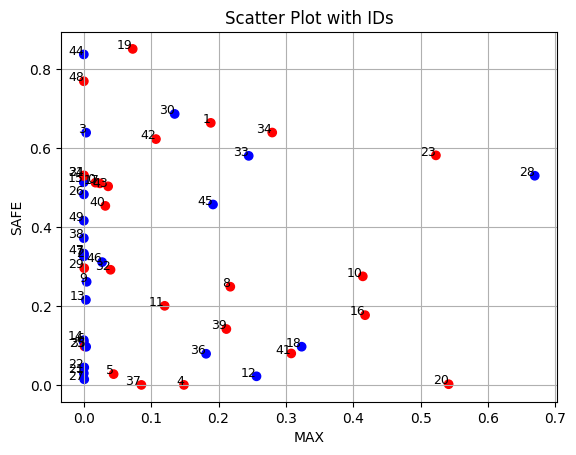

In [86]:
dist_type = 'gamma'
X = [out[dist_type] for out in p_max_margins]
Y = [out[dist_type] for out in p_safe_margins]


plt.scatter(X, Y, c=['red' if gt else 'blue' for gt in ground_truths])

for i, (xi, yi) in enumerate(zip(X, Y)):
    plt.text(xi, yi, str(i), fontsize=9, ha='right')

plt.xlabel('MAX')
plt.ylabel('SAFE')
plt.title('Scatter Plot with IDs')
plt.grid(True)
plt.show()



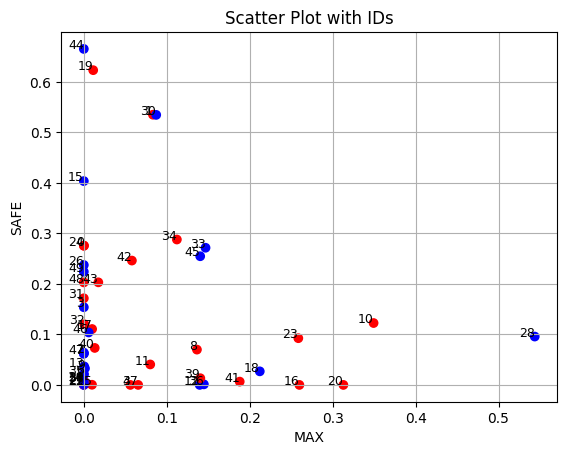

In [87]:
dist_type = 'norm'
X = [out[dist_type] for out in p_max_margins]
Y = [out[dist_type] for out in p_safe_margins]

plt.scatter(X, Y, c=['red' if gt else 'blue' for gt in ground_truths])

for i, (xi, yi) in enumerate(zip(X, Y)):
    plt.text(xi, yi, str(i), fontsize=9, ha='right')

plt.xlabel('MAX')
plt.ylabel('SAFE')
plt.title('Scatter Plot with IDs')
plt.grid(True)
plt.show()



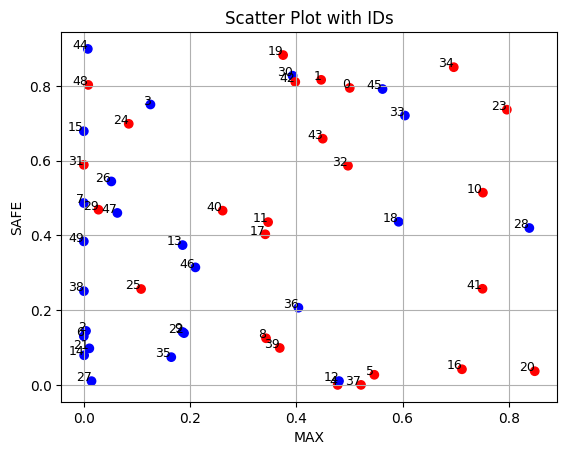

In [88]:
dist_type = 'expon'
X = [out[dist_type] for out in p_max_margins]
Y = [out[dist_type] for out in p_safe_margins]

plt.scatter(X, Y, c=['red' if gt else 'blue' for gt in ground_truths])

for i, (xi, yi) in enumerate(zip(X, Y)):
    plt.text(xi, yi, str(i), fontsize=9, ha='right')

plt.xlabel('MAX')
plt.ylabel('SAFE')
plt.title('Scatter Plot with IDs')
plt.grid(True)
plt.show()

